# Credit Card Default
August 16, 2019<br>Anthony & Ngoc, Best Model

-----------------------------------------------------------------

In this notebook, we will show our best model.

----------------------------------------------

# Import

In [1]:
%matplotlib inline

import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.svm import SVC
from datetime import datetime
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_curve, roc_auc_score

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Change directory to get data source code:

In [2]:
main_path = os.getcwd()
parent_path = Path(os.getcwd()).parent
src_path = str(parent_path) + "/src/directories"
os.chdir(src_path)

More import:

In [3]:
import change_directory

Change back to notebook directory:

In [4]:
os.chdir(main_path)

Change directory to get helper functions:

In [5]:
cd = change_directory.ChangeDirectory()

In [6]:
cd.change_to_src_models_dir()

More import:

In [7]:
import evaluation_functions
all_scores = evaluation_functions.all_scores
scores_confusion_matrix = evaluation_functions.scores_confusion_matrix
sbs = evaluation_functions.scores_of_best_search

Change back to notebook directory:

In [8]:
cd.change_to_notebook_dir()

# ETL

## Load data

Change directory to get data:

In [9]:
cd.change_to_data_dir()

Load data:

In [10]:
ccd_df = pd.read_csv("processed/transformed_credit_card_default.csv")

Change back to notebook directory:

In [11]:
cd.change_to_notebook_dir()

## Sample data
Methods to tackle imbalance: over-sampling, under-sampling, and SMOTE.

In [12]:
ccd_df.drop("Unnamed: 0", axis=1, inplace=True)

In [13]:
ccd_ns = ccd_df.copy()
ccd_ou = ccd_df.copy()
ccd_smote = ccd_df.copy()

### Over-sampling

In [14]:
default_samples = ccd_ou[ccd_ou.DEFAULT == 1]
non_default_samples = ccd_ou[ccd_ou.DEFAULT == 0]

In [15]:
default_samples_train, default_samples_test = train_test_split(default_samples,
                                                               test_size=0.2,
                                                               random_state=111)
non_default_samples_train, non_default_samples_test = train_test_split(non_default_samples,
                                                                       test_size=0.2,
                                                                       random_state=111)

In [16]:
np.random.seed(42)
os_default_idx = np.random.choice(default_samples_train.index,
                                  size=non_default_samples_train.shape[0], replace=True)
os_default = default_samples_train.loc[os_default_idx, :]

In [17]:
ccd_over_sampled_train = pd.concat([os_default, non_default_samples_train], axis=0)
X_over_sampled_train = ccd_over_sampled_train.drop("DEFAULT", axis=1)
y_over_sampled_train = ccd_over_sampled_train.DEFAULT

ccd_over_sampled_test = pd.concat([default_samples_test, non_default_samples_test], axis=0)
X_over_sampled_test = ccd_over_sampled_test.drop("DEFAULT", axis=1)
y_over_sampled_test = ccd_over_sampled_test.DEFAULT

### Under-sampling

In [18]:
np.random.seed(42)
us_non_default_idx = np.random.choice(non_default_samples.index, size=default_samples.shape[0], replace=False)
us_non_default = non_default_samples.loc[us_non_default_idx, :]

In [19]:
ccd_under_sampled = pd.concat([us_non_default, default_samples], axis=0)
X_under_sampled = ccd_under_sampled.drop("DEFAULT", axis=1)
y_under_sampled = ccd_under_sampled.DEFAULT
X_under_sampled_train, X_under_sampled_test, y_under_sampled_train, y_under_sampled_test = train_test_split(
    X_under_sampled, y_under_sampled, test_size=0.2, random_state=111)

### SMOTE

In [20]:
X_smote = ccd_smote.drop("DEFAULT", axis=1)
y_smote = ccd_smote.DEFAULT
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote,
                                                                            test_size=0.2, random_state=111)
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_smote_train, y_smote_train)

## Data for modeling

In [21]:
# non-sampled
X_non_sampled = ccd_ns.drop("DEFAULT", axis=1)
y_non_sampled = ccd_ns.DEFAULT
non_sampled_X_train, non_sampled_X_test, non_sampled_y_train, non_sampled_y_test = train_test_split(X_non_sampled,
                                                                                                    y_non_sampled,
                                                                                                    test_size=0.2,
                                                                                                    random_state=111)

In [22]:
# over-sampled
over_sampled_X_train = X_over_sampled_train
over_sampled_y_train = y_over_sampled_train
over_sampled_X_test = X_over_sampled_test
over_sampled_y_test = y_over_sampled_test

In [23]:
# under-sampled
under_sampled_X_train = X_under_sampled_train
under_sampled_y_train = y_under_sampled_train
under_sampled_X_test = X_under_sampled_test
under_sampled_y_test = y_under_sampled_test

In [24]:
# SMOTE
smote_sampled_X_train = X_sm
smote_sampled_y_train = y_sm
smote_sampled_X_test = X_smote_test
smote_sampled_y_test = y_smote_test

# Model

Change directory to get models:

In [25]:
cd.change_to_model_dir()

Load models:

In [26]:
with open("transformed_non_sampled_logistic_regression.pickle", "rb") as f:
    t_ns_lr_gs = pickle.load(f)
    
with open("transformed_non_sampled_decision_tree.pickle", "rb") as f:
    t_ns_dt_gs = pickle.load(f)
    
with open("transformed_non_sampled_random_forest.pickle", "rb") as f:
    t_ns_rf_gs = pickle.load(f)
    
with open("transformed_over_sampled_logistic_regression.pickle", "rb") as f:
    t_os_lr_gs = pickle.load(f)
    
with open("transformed_over_sampled_decision_tree.pickle", "rb") as f:
    t_os_dt_gs = pickle.load(f)
    
with open("transformed_over_sampled_random_forest.pickle", "rb") as f:
    t_os_rf_gs = pickle.load(f)
    
with open("transformed_under_sampled_logistic_regression.pickle", "rb") as f:
    t_us_lr_gs = pickle.load(f)
    
with open("transformed_under_sampled_decision_tree.pickle", "rb") as f:
    t_us_dt_gs = pickle.load(f)
    
with open("transformed_under_sampled_random_forest.pickle", "rb") as f:
    t_us_rf_gs = pickle.load(f)
    
with open("transformed_smote_sampled_logistic_regression.pickle", "rb") as f:
    t_sm_lr_gs = pickle.load(f)
    
with open("transformed_smote_sampled_decision_tree.pickle", "rb") as f:
    t_sm_dt_gs = pickle.load(f)
    
with open("transformed_smote_sampled_random_forest.pickle", "rb") as f:
    t_sm_rf_gs = pickle.load(f)

Change back to notebook directory:

In [27]:
cd.change_to_notebook_dir()

In [28]:
t_ns_dt_scores = sbs(t_ns_dt_gs, 
                     non_sampled_X_train, 
                     non_sampled_X_test,
                     non_sampled_y_train,
                     non_sampled_y_test);

t_os_dt_scores = sbs(t_os_dt_gs, 
                     X_over_sampled_train,
                     X_over_sampled_test,
                     y_over_sampled_train,
                     y_over_sampled_test);

t_us_dt_scores = sbs(t_us_dt_gs, 
                     X_under_sampled_train,
                     X_under_sampled_test,
                     y_under_sampled_train,
                     y_under_sampled_test);

t_sm_dt_scores = sbs(t_sm_dt_gs, 
                     X_sm,
                     X_smote_test,
                     y_sm,
                     y_smote_test);


Text(0.5,1,'Recall and F-1 Score of Different Decision Trees')

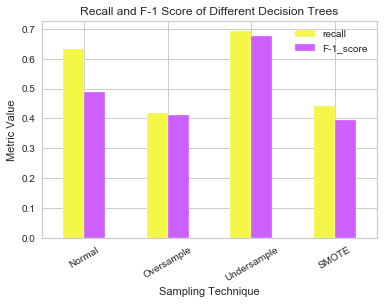

In [29]:
colors = [np.array([245, 247, 72])/255, np.array([205, 96, 252])/255]

pd.DataFrame([t_ns_dt_scores, t_os_dt_scores, t_us_dt_scores,
              t_sm_dt_scores], columns=['recall', 'precision', 'F-1_score'],
             index=['Normal',
                    'Oversample', 
                    'Undersample', 
                    'SMOTE'])[['recall', 'F-1_score']].plot(kind='bar', color=colors, rot=30)
plt.xlabel("Sampling Technique")
plt.ylabel("Metric Value")
plt.title("Recall and F-1 Score of Different Decision Trees")

In [30]:
t_us_rf_scores = sbs(t_us_rf_gs, 
                     X_under_sampled_train,
                     X_under_sampled_test,
                     y_under_sampled_train,
                     y_under_sampled_test);

t_us_lr_scores = sbs(t_us_lr_gs, 
                     X_under_sampled_train,
                     X_under_sampled_test,
                     y_under_sampled_train,
                     y_under_sampled_test);

Text(0,0.5,'Metric Value')

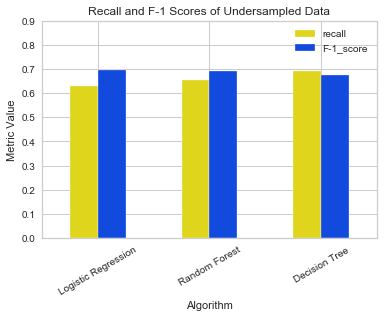

In [31]:
colors2 = [np.array([223, 213, 29])/255, np.array([17, 74, 221])/255]

pd.DataFrame([t_us_lr_scores, t_us_rf_scores, t_us_dt_scores],
             columns=['recall', 'precision', 'F-1_score'],
             index=['Logistic Regression', 
                    'Random Forest', 
                    'Decision Tree'])[['recall', 'F-1_score']].plot(kind='bar',color=colors2, rot=30)
plt.ylim([0, .9])
plt.title('Recall and F-1 Scores of Undersampled Data')
plt.xlabel("Algorithm")
plt.ylabel("Metric Value")